In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 drehrsxe


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-drehrsxe:best, 314.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:9.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                      | 1/2604 [00:00<26:25,  1.64it/s]

  0%|▎                                                                                                                     | 6/2604 [00:00<04:06, 10.55it/s]

  0%|▍                                                                                                                    | 11/2604 [00:00<02:18, 18.70it/s]

  1%|▋                                                                                                                    | 16/2604 [00:00<01:40, 25.72it/s]

  1%|▉                                                                                                                    | 21/2604 [00:01<01:21, 31.60it/s]

  1%|█▏                                                                                                                   | 26/2604 [00:01<01:11, 36.19it/s]

  1%|█▍                                                                                                                   | 31/2604 [00:01<01:04, 39.82it/s]

  1%|█▌                                                                                                                   | 36/2604 [00:01<01:00, 42.39it/s]

  2%|█▊                                                                                                                   | 41/2604 [00:01<00:57, 44.34it/s]

  2%|██                                                                                                                   | 46/2604 [00:01<00:55, 45.84it/s]

  2%|██▎                                                                                                                  | 51/2604 [00:01<00:54, 46.96it/s]

  2%|██▌                                                                                                                  | 56/2604 [00:01<00:53, 47.74it/s]

  2%|██▋                                                                                                                  | 61/2604 [00:01<00:52, 48.31it/s]

  3%|██▉                                                                                                                  | 66/2604 [00:01<00:52, 48.72it/s]

  3%|███▏                                                                                                                 | 71/2604 [00:02<00:51, 48.97it/s]

  3%|███▍                                                                                                                 | 76/2604 [00:02<00:51, 49.14it/s]

  3%|███▋                                                                                                                 | 81/2604 [00:02<00:51, 49.29it/s]

  3%|███▊                                                                                                                 | 86/2604 [00:02<00:50, 49.39it/s]

  3%|████                                                                                                                 | 91/2604 [00:02<00:50, 49.47it/s]

  4%|████▎                                                                                                                | 96/2604 [00:02<00:50, 49.38it/s]

  4%|████▍                                                                                                               | 101/2604 [00:02<00:50, 49.46it/s]

  4%|████▋                                                                                                               | 106/2604 [00:02<00:50, 49.46it/s]

  4%|████▉                                                                                                               | 111/2604 [00:02<00:50, 49.54it/s]

  4%|█████▏                                                                                                              | 116/2604 [00:02<00:50, 49.57it/s]

  5%|█████▍                                                                                                              | 121/2604 [00:03<00:50, 49.59it/s]

  5%|█████▌                                                                                                              | 126/2604 [00:03<00:49, 49.60it/s]

  5%|█████▊                                                                                                              | 131/2604 [00:03<00:50, 49.45it/s]

  5%|██████                                                                                                              | 136/2604 [00:03<00:49, 49.45it/s]

  5%|██████▎                                                                                                             | 141/2604 [00:03<00:49, 49.49it/s]

  6%|██████▌                                                                                                             | 146/2604 [00:03<00:49, 49.52it/s]

  6%|██████▋                                                                                                             | 151/2604 [00:03<00:49, 49.41it/s]

  6%|██████▉                                                                                                             | 156/2604 [00:03<00:49, 49.44it/s]

  6%|███████▏                                                                                                            | 161/2604 [00:03<00:49, 49.49it/s]

  6%|███████▍                                                                                                            | 166/2604 [00:03<00:49, 49.53it/s]

  7%|███████▌                                                                                                            | 171/2604 [00:04<00:49, 49.56it/s]

  7%|███████▊                                                                                                            | 176/2604 [00:04<00:48, 49.58it/s]

  7%|████████                                                                                                            | 181/2604 [00:04<00:48, 49.58it/s]

  7%|████████▎                                                                                                           | 186/2604 [00:04<00:48, 49.58it/s]

  7%|████████▌                                                                                                           | 191/2604 [00:04<00:48, 49.62it/s]

  8%|████████▋                                                                                                           | 196/2604 [00:04<00:48, 49.61it/s]

  8%|████████▉                                                                                                           | 201/2604 [00:04<00:48, 49.63it/s]

  8%|█████████▏                                                                                                          | 206/2604 [00:04<00:48, 49.63it/s]

  8%|█████████▍                                                                                                          | 211/2604 [00:04<00:48, 49.33it/s]

  8%|█████████▌                                                                                                          | 216/2604 [00:04<00:48, 49.43it/s]

  8%|█████████▊                                                                                                          | 221/2604 [00:05<00:48, 49.48it/s]

  9%|██████████                                                                                                          | 226/2604 [00:05<00:48, 49.52it/s]

  9%|██████████▎                                                                                                         | 231/2604 [00:05<00:47, 49.57it/s]

  9%|██████████▌                                                                                                         | 236/2604 [00:05<00:47, 49.59it/s]

  9%|██████████▋                                                                                                         | 241/2604 [00:05<00:47, 49.61it/s]

  9%|██████████▉                                                                                                         | 246/2604 [00:05<00:47, 49.66it/s]

 10%|███████████▏                                                                                                        | 251/2604 [00:05<00:47, 49.72it/s]

 10%|███████████▍                                                                                                        | 257/2604 [00:05<00:46, 50.16it/s]

 10%|███████████▋                                                                                                        | 263/2604 [00:05<00:46, 50.62it/s]

 10%|███████████▉                                                                                                        | 269/2604 [00:06<00:45, 50.97it/s]

 11%|████████████▎                                                                                                       | 275/2604 [00:06<00:45, 51.22it/s]

 11%|████████████▌                                                                                                       | 281/2604 [00:06<00:45, 51.20it/s]

 11%|████████████▊                                                                                                       | 287/2604 [00:06<00:45, 51.02it/s]

 11%|█████████████                                                                                                       | 293/2604 [00:06<00:45, 50.63it/s]

 11%|█████████████▎                                                                                                      | 299/2604 [00:06<00:45, 50.26it/s]

 12%|█████████████▌                                                                                                      | 305/2604 [00:06<00:45, 50.14it/s]

 12%|█████████████▊                                                                                                      | 311/2604 [00:06<00:45, 50.05it/s]

 12%|██████████████                                                                                                      | 317/2604 [00:06<00:45, 49.85it/s]

 12%|██████████████▎                                                                                                     | 322/2604 [00:07<00:45, 49.85it/s]

 13%|██████████████▌                                                                                                     | 327/2604 [00:07<00:45, 49.81it/s]

 13%|██████████████▊                                                                                                     | 332/2604 [00:07<00:45, 49.75it/s]

 13%|███████████████                                                                                                     | 337/2604 [00:07<00:45, 49.74it/s]

 13%|███████████████▏                                                                                                    | 342/2604 [00:07<00:45, 49.70it/s]

 13%|███████████████▍                                                                                                    | 347/2604 [00:07<00:45, 49.71it/s]

 14%|███████████████▋                                                                                                    | 352/2604 [00:07<00:45, 49.73it/s]

 14%|███████████████▉                                                                                                    | 357/2604 [00:07<00:45, 49.70it/s]

 14%|████████████████▏                                                                                                   | 362/2604 [00:07<00:45, 49.79it/s]

 14%|████████████████▎                                                                                                   | 367/2604 [00:07<00:45, 49.61it/s]

 14%|████████████████▌                                                                                                   | 372/2604 [00:08<00:44, 49.63it/s]

 14%|████████████████▊                                                                                                   | 377/2604 [00:08<00:44, 49.65it/s]

 15%|█████████████████                                                                                                   | 382/2604 [00:08<00:44, 49.66it/s]

 15%|█████████████████▏                                                                                                  | 387/2604 [00:08<00:44, 49.67it/s]

 15%|█████████████████▍                                                                                                  | 392/2604 [00:08<00:44, 49.66it/s]

 15%|█████████████████▋                                                                                                  | 397/2604 [00:08<00:44, 49.63it/s]

 15%|█████████████████▉                                                                                                  | 402/2604 [00:08<00:44, 49.60it/s]

 16%|██████████████████▏                                                                                                 | 408/2604 [00:08<00:44, 49.77it/s]

 16%|██████████████████▍                                                                                                 | 413/2604 [00:08<00:44, 49.59it/s]

 16%|██████████████████▌                                                                                                 | 418/2604 [00:09<00:44, 49.60it/s]

 16%|██████████████████▊                                                                                                 | 423/2604 [00:09<00:43, 49.62it/s]

 16%|███████████████████                                                                                                 | 428/2604 [00:09<00:43, 49.66it/s]

 17%|███████████████████▎                                                                                                | 433/2604 [00:09<00:43, 49.68it/s]

 17%|███████████████████▌                                                                                                | 438/2604 [00:09<00:43, 49.68it/s]

 17%|███████████████████▋                                                                                                | 443/2604 [00:09<00:43, 49.68it/s]

 17%|███████████████████▉                                                                                                | 448/2604 [00:09<00:43, 49.66it/s]

 17%|████████████████████▏                                                                                               | 453/2604 [00:09<00:43, 49.60it/s]

 18%|████████████████████▍                                                                                               | 458/2604 [00:09<00:43, 49.61it/s]

 18%|████████████████████▋                                                                                               | 463/2604 [00:09<00:43, 49.53it/s]

 18%|████████████████████▊                                                                                               | 468/2604 [00:10<00:43, 49.57it/s]

 18%|█████████████████████                                                                                               | 473/2604 [00:10<00:42, 49.60it/s]

 18%|█████████████████████▎                                                                                              | 478/2604 [00:10<00:42, 49.64it/s]

 19%|█████████████████████▌                                                                                              | 483/2604 [00:10<00:42, 49.68it/s]

 19%|█████████████████████▋                                                                                              | 488/2604 [00:10<00:42, 49.69it/s]

 19%|█████████████████████▉                                                                                              | 493/2604 [00:10<00:42, 49.67it/s]

 19%|██████████████████████▏                                                                                             | 498/2604 [00:10<00:42, 49.67it/s]

 19%|██████████████████████▍                                                                                             | 503/2604 [00:10<00:42, 49.67it/s]

 20%|██████████████████████▋                                                                                             | 508/2604 [00:10<00:42, 49.66it/s]

 20%|██████████████████████▊                                                                                             | 513/2604 [00:10<00:42, 49.47it/s]

 20%|███████████████████████                                                                                             | 518/2604 [00:11<00:42, 49.54it/s]

 20%|███████████████████████▎                                                                                            | 523/2604 [00:11<00:42, 49.54it/s]

 20%|███████████████████████▌                                                                                            | 528/2604 [00:11<00:41, 49.56it/s]

 20%|███████████████████████▋                                                                                            | 533/2604 [00:11<00:41, 49.58it/s]

 21%|███████████████████████▉                                                                                            | 538/2604 [00:11<00:41, 49.61it/s]

 21%|████████████████████████▏                                                                                           | 543/2604 [00:11<00:41, 49.62it/s]

 21%|████████████████████████▍                                                                                           | 548/2604 [00:11<00:41, 49.63it/s]

 21%|████████████████████████▋                                                                                           | 553/2604 [00:11<00:41, 49.64it/s]

 21%|████████████████████████▊                                                                                           | 558/2604 [00:11<00:41, 49.66it/s]

 22%|█████████████████████████                                                                                           | 563/2604 [00:11<00:41, 49.67it/s]

 22%|█████████████████████████▎                                                                                          | 568/2604 [00:12<00:40, 49.67it/s]

 22%|█████████████████████████▌                                                                                          | 573/2604 [00:12<00:41, 49.52it/s]

 22%|█████████████████████████▋                                                                                          | 578/2604 [00:12<00:40, 49.53it/s]

 22%|█████████████████████████▉                                                                                          | 583/2604 [00:12<00:40, 49.59it/s]

 23%|██████████████████████████▏                                                                                         | 588/2604 [00:12<00:40, 49.62it/s]

 23%|██████████████████████████▍                                                                                         | 593/2604 [00:12<00:40, 49.62it/s]

 23%|██████████████████████████▋                                                                                         | 598/2604 [00:12<00:40, 49.62it/s]

 23%|██████████████████████████▊                                                                                         | 603/2604 [00:12<00:40, 49.63it/s]

 23%|███████████████████████████                                                                                         | 608/2604 [00:12<00:40, 49.66it/s]

 24%|███████████████████████████▎                                                                                        | 613/2604 [00:12<00:40, 49.67it/s]

 24%|███████████████████████████▌                                                                                        | 618/2604 [00:13<00:39, 49.67it/s]

 24%|███████████████████████████▊                                                                                        | 623/2604 [00:13<00:39, 49.53it/s]

 24%|███████████████████████████▉                                                                                        | 628/2604 [00:13<00:39, 49.53it/s]

 24%|████████████████████████████▏                                                                                       | 633/2604 [00:13<00:39, 49.57it/s]

 25%|████████████████████████████▍                                                                                       | 638/2604 [00:13<00:39, 49.60it/s]

 25%|████████████████████████████▋                                                                                       | 643/2604 [00:13<00:39, 49.61it/s]

 25%|████████████████████████████▊                                                                                       | 648/2604 [00:13<00:39, 49.59it/s]

 25%|█████████████████████████████                                                                                       | 653/2604 [00:13<00:39, 49.58it/s]

 25%|█████████████████████████████▎                                                                                      | 659/2604 [00:13<00:39, 49.63it/s]

 25%|█████████████████████████████▌                                                                                      | 664/2604 [00:13<00:39, 49.63it/s]

 26%|█████████████████████████████▊                                                                                      | 669/2604 [00:14<00:38, 49.63it/s]

 26%|██████████████████████████████                                                                                      | 674/2604 [00:14<00:38, 49.64it/s]

 26%|██████████████████████████████▏                                                                                     | 679/2604 [00:14<00:38, 49.64it/s]

 26%|██████████████████████████████▍                                                                                     | 684/2604 [00:14<00:38, 49.65it/s]

 26%|██████████████████████████████▋                                                                                     | 689/2604 [00:14<00:38, 49.68it/s]

 27%|██████████████████████████████▉                                                                                     | 694/2604 [00:14<00:38, 49.68it/s]

 27%|███████████████████████████████▏                                                                                    | 699/2604 [00:14<00:38, 49.69it/s]

 27%|███████████████████████████████▎                                                                                    | 704/2604 [00:14<00:38, 49.63it/s]

 27%|███████████████████████████████▌                                                                                    | 709/2604 [00:14<00:38, 49.66it/s]

 27%|███████████████████████████████▊                                                                                    | 714/2604 [00:14<00:38, 49.67it/s]

 28%|████████████████████████████████                                                                                    | 719/2604 [00:15<00:38, 49.53it/s]

 28%|████████████████████████████████▎                                                                                   | 724/2604 [00:15<00:37, 49.57it/s]

 28%|████████████████████████████████▍                                                                                   | 729/2604 [00:15<00:37, 49.57it/s]

 28%|████████████████████████████████▋                                                                                   | 734/2604 [00:15<00:37, 49.63it/s]

 28%|████████████████████████████████▉                                                                                   | 739/2604 [00:15<00:37, 49.66it/s]

 29%|█████████████████████████████████▏                                                                                  | 744/2604 [00:15<00:37, 49.67it/s]

 29%|█████████████████████████████████▎                                                                                  | 749/2604 [00:15<00:37, 49.67it/s]

 29%|█████████████████████████████████▌                                                                                  | 754/2604 [00:15<00:37, 49.70it/s]

 29%|█████████████████████████████████▊                                                                                  | 759/2604 [00:15<00:37, 49.68it/s]

 29%|██████████████████████████████████                                                                                  | 764/2604 [00:15<00:37, 49.67it/s]

 30%|██████████████████████████████████▎                                                                                 | 769/2604 [00:16<00:37, 49.53it/s]

 30%|██████████████████████████████████▍                                                                                 | 774/2604 [00:16<00:36, 49.57it/s]

 30%|██████████████████████████████████▋                                                                                 | 779/2604 [00:16<00:36, 49.54it/s]

 30%|██████████████████████████████████▉                                                                                 | 784/2604 [00:16<00:36, 49.52it/s]

 30%|███████████████████████████████████▏                                                                                | 789/2604 [00:16<00:36, 49.57it/s]

 30%|███████████████████████████████████▎                                                                                | 794/2604 [00:16<00:36, 49.62it/s]

 31%|███████████████████████████████████▌                                                                                | 799/2604 [00:16<00:36, 49.63it/s]

 31%|███████████████████████████████████▊                                                                                | 804/2604 [00:16<00:36, 49.64it/s]

 31%|████████████████████████████████████                                                                                | 809/2604 [00:16<00:36, 49.62it/s]

 31%|████████████████████████████████████▎                                                                               | 814/2604 [00:16<00:36, 49.62it/s]

 31%|████████████████████████████████████▍                                                                               | 819/2604 [00:17<00:36, 49.44it/s]

 32%|████████████████████████████████████▊                                                                               | 825/2604 [00:17<00:35, 49.67it/s]

 32%|████████████████████████████████████▉                                                                               | 830/2604 [00:17<00:35, 49.68it/s]

 32%|█████████████████████████████████████▏                                                                              | 835/2604 [00:17<00:35, 49.70it/s]

 32%|█████████████████████████████████████▍                                                                              | 840/2604 [00:17<00:35, 49.69it/s]

 32%|█████████████████████████████████████▋                                                                              | 845/2604 [00:17<00:35, 49.69it/s]

 33%|█████████████████████████████████████▊                                                                              | 850/2604 [00:17<00:35, 49.67it/s]

 33%|██████████████████████████████████████                                                                              | 855/2604 [00:17<00:35, 49.70it/s]

 33%|██████████████████████████████████████▎                                                                             | 860/2604 [00:17<00:35, 49.69it/s]

 33%|██████████████████████████████████████▌                                                                             | 865/2604 [00:18<00:34, 49.70it/s]

 33%|██████████████████████████████████████▊                                                                             | 870/2604 [00:18<00:34, 49.68it/s]

 34%|██████████████████████████████████████▉                                                                             | 875/2604 [00:18<00:34, 49.66it/s]

 34%|███████████████████████████████████████▏                                                                            | 880/2604 [00:18<00:34, 49.53it/s]

 34%|███████████████████████████████████████▍                                                                            | 885/2604 [00:18<00:34, 49.62it/s]

 34%|███████████████████████████████████████▋                                                                            | 890/2604 [00:18<00:34, 49.64it/s]

 34%|███████████████████████████████████████▊                                                                            | 895/2604 [00:18<00:34, 49.67it/s]

 35%|████████████████████████████████████████                                                                            | 900/2604 [00:18<00:34, 49.70it/s]

 35%|████████████████████████████████████████▎                                                                           | 905/2604 [00:18<00:34, 49.71it/s]

 35%|████████████████████████████████████████▌                                                                           | 910/2604 [00:18<00:34, 49.72it/s]

 35%|████████████████████████████████████████▊                                                                           | 915/2604 [00:19<00:34, 49.54it/s]

 35%|████████████████████████████████████████▉                                                                           | 920/2604 [00:19<00:33, 49.54it/s]

 36%|█████████████████████████████████████████▏                                                                          | 925/2604 [00:19<00:33, 49.39it/s]

 36%|█████████████████████████████████████████▍                                                                          | 930/2604 [00:19<00:33, 49.48it/s]

 36%|█████████████████████████████████████████▋                                                                          | 935/2604 [00:19<00:33, 49.53it/s]

 36%|█████████████████████████████████████████▊                                                                          | 940/2604 [00:19<00:33, 49.57it/s]

 36%|██████████████████████████████████████████                                                                          | 945/2604 [00:19<00:33, 49.60it/s]

 36%|██████████████████████████████████████████▎                                                                         | 950/2604 [00:19<00:33, 49.63it/s]

 37%|██████████████████████████████████████████▌                                                                         | 955/2604 [00:19<00:34, 48.27it/s]

 37%|██████████████████████████████████████████▊                                                                         | 960/2604 [00:19<00:33, 48.69it/s]

 37%|██████████████████████████████████████████▉                                                                         | 965/2604 [00:20<00:33, 48.96it/s]

 37%|███████████████████████████████████████████▏                                                                        | 970/2604 [00:20<00:33, 49.09it/s]

 37%|███████████████████████████████████████████▍                                                                        | 975/2604 [00:20<00:33, 49.26it/s]

 38%|███████████████████████████████████████████▋                                                                        | 980/2604 [00:20<00:32, 49.39it/s]

 38%|███████████████████████████████████████████▉                                                                        | 985/2604 [00:20<00:32, 49.47it/s]

 38%|████████████████████████████████████████████                                                                        | 990/2604 [00:20<00:32, 49.51it/s]

 38%|████████████████████████████████████████████▎                                                                       | 995/2604 [00:20<00:32, 49.40it/s]

 38%|████████████████████████████████████████████▏                                                                      | 1000/2604 [00:20<00:32, 49.51it/s]

 39%|████████████████████████████████████████████▍                                                                      | 1005/2604 [00:20<00:32, 49.55it/s]

 39%|████████████████████████████████████████████▌                                                                      | 1010/2604 [00:20<00:32, 49.57it/s]

 39%|████████████████████████████████████████████▊                                                                      | 1015/2604 [00:21<00:32, 49.61it/s]

 39%|█████████████████████████████████████████████                                                                      | 1020/2604 [00:21<00:31, 49.62it/s]

 39%|█████████████████████████████████████████████▎                                                                     | 1025/2604 [00:21<00:31, 49.62it/s]

 40%|█████████████████████████████████████████████▍                                                                     | 1030/2604 [00:21<00:31, 49.66it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 1035/2604 [00:21<00:31, 49.64it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 1040/2604 [00:21<00:31, 49.66it/s]

 40%|██████████████████████████████████████████████▏                                                                    | 1045/2604 [00:21<00:31, 49.56it/s]

 40%|██████████████████████████████████████████████▎                                                                    | 1050/2604 [00:21<00:31, 49.61it/s]

 41%|██████████████████████████████████████████████▌                                                                    | 1055/2604 [00:21<00:31, 49.48it/s]

 41%|██████████████████████████████████████████████▊                                                                    | 1060/2604 [00:21<00:31, 49.55it/s]

 41%|███████████████████████████████████████████████                                                                    | 1065/2604 [00:22<00:31, 49.61it/s]

 41%|███████████████████████████████████████████████▎                                                                   | 1070/2604 [00:22<00:30, 49.64it/s]

 41%|███████████████████████████████████████████████▍                                                                   | 1075/2604 [00:22<00:30, 49.66it/s]

 41%|███████████████████████████████████████████████▋                                                                   | 1080/2604 [00:22<00:30, 49.67it/s]

 42%|███████████████████████████████████████████████▉                                                                   | 1085/2604 [00:22<00:30, 49.69it/s]

 42%|████████████████████████████████████████████████▏                                                                  | 1090/2604 [00:22<00:30, 49.67it/s]

 42%|████████████████████████████████████████████████▍                                                                  | 1096/2604 [00:22<00:30, 50.10it/s]

 42%|████████████████████████████████████████████████▋                                                                  | 1102/2604 [00:22<00:29, 50.47it/s]

 43%|████████████████████████████████████████████████▉                                                                  | 1108/2604 [00:22<00:29, 50.84it/s]

 43%|█████████████████████████████████████████████████▏                                                                 | 1114/2604 [00:23<00:29, 51.09it/s]

 43%|█████████████████████████████████████████████████▍                                                                 | 1120/2604 [00:23<00:29, 51.09it/s]

 43%|█████████████████████████████████████████████████▋                                                                 | 1126/2604 [00:23<00:28, 51.13it/s]

 43%|█████████████████████████████████████████████████▉                                                                 | 1132/2604 [00:23<00:28, 51.28it/s]

 44%|██████████████████████████████████████████████████▎                                                                | 1138/2604 [00:23<00:28, 51.25it/s]

 44%|██████████████████████████████████████████████████▌                                                                | 1144/2604 [00:23<00:28, 51.36it/s]

 44%|██████████████████████████████████████████████████▊                                                                | 1150/2604 [00:23<00:28, 51.44it/s]

 44%|███████████████████████████████████████████████████                                                                | 1156/2604 [00:23<00:28, 51.50it/s]

 45%|███████████████████████████████████████████████████▎                                                               | 1162/2604 [00:23<00:28, 51.44it/s]

 45%|███████████████████████████████████████████████████▌                                                               | 1168/2604 [00:24<00:28, 51.27it/s]

 45%|███████████████████████████████████████████████████▊                                                               | 1174/2604 [00:24<00:27, 51.16it/s]

 45%|████████████████████████████████████████████████████                                                               | 1180/2604 [00:24<00:28, 50.64it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 1186/2604 [00:24<00:28, 50.38it/s]

 46%|████████████████████████████████████████████████████▋                                                              | 1192/2604 [00:24<00:28, 50.21it/s]

 46%|████████████████████████████████████████████████████▉                                                              | 1198/2604 [00:24<00:28, 49.93it/s]

 46%|█████████████████████████████████████████████████████▏                                                             | 1203/2604 [00:24<00:28, 49.73it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 1208/2604 [00:24<00:28, 49.67it/s]

 47%|█████████████████████████████████████████████████████▌                                                             | 1213/2604 [00:24<00:28, 49.68it/s]

 47%|█████████████████████████████████████████████████████▊                                                             | 1218/2604 [00:25<00:27, 49.69it/s]

 47%|██████████████████████████████████████████████████████                                                             | 1223/2604 [00:25<00:27, 49.68it/s]

 47%|██████████████████████████████████████████████████████▏                                                            | 1228/2604 [00:25<00:27, 49.67it/s]

 47%|██████████████████████████████████████████████████████▍                                                            | 1233/2604 [00:25<00:27, 49.68it/s]

 48%|██████████████████████████████████████████████████████▋                                                            | 1238/2604 [00:25<00:27, 49.72it/s]

 48%|██████████████████████████████████████████████████████▉                                                            | 1243/2604 [00:25<00:27, 49.73it/s]

 48%|███████████████████████████████████████████████████████                                                            | 1248/2604 [00:25<00:27, 49.72it/s]

 48%|███████████████████████████████████████████████████████▎                                                           | 1253/2604 [00:25<00:27, 49.51it/s]

 48%|███████████████████████████████████████████████████████▌                                                           | 1258/2604 [00:25<00:27, 49.57it/s]

 49%|███████████████████████████████████████████████████████▊                                                           | 1263/2604 [00:25<00:27, 49.62it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 1268/2604 [00:26<00:26, 49.63it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 1273/2604 [00:26<00:26, 49.63it/s]

 49%|████████████████████████████████████████████████████████▍                                                          | 1278/2604 [00:26<00:26, 49.62it/s]

 49%|████████████████████████████████████████████████████████▋                                                          | 1283/2604 [00:26<00:26, 49.62it/s]

 49%|████████████████████████████████████████████████████████▉                                                          | 1288/2604 [00:26<00:26, 49.66it/s]

 50%|█████████████████████████████████████████████████████████                                                          | 1293/2604 [00:26<00:26, 49.70it/s]

 50%|█████████████████████████████████████████████████████████▎                                                         | 1298/2604 [00:26<00:26, 49.70it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 1303/2604 [00:26<00:26, 49.67it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 1308/2604 [00:26<00:26, 49.53it/s]

 50%|█████████████████████████████████████████████████████████▉                                                         | 1313/2604 [00:27<00:26, 49.47it/s]

 51%|██████████████████████████████████████████████████████████▏                                                        | 1318/2604 [00:27<00:25, 49.50it/s]

 51%|██████████████████████████████████████████████████████████▍                                                        | 1323/2604 [00:27<00:25, 49.57it/s]

 51%|██████████████████████████████████████████████████████████▋                                                        | 1328/2604 [00:27<00:25, 49.61it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 1333/2604 [00:27<00:25, 49.62it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 1338/2604 [00:27<00:25, 49.65it/s]

 52%|███████████████████████████████████████████████████████████▎                                                       | 1343/2604 [00:27<00:25, 49.65it/s]

 52%|███████████████████████████████████████████████████████████▌                                                       | 1348/2604 [00:27<00:25, 49.65it/s]

 52%|███████████████████████████████████████████████████████████▊                                                       | 1353/2604 [00:27<00:25, 49.70it/s]

 52%|███████████████████████████████████████████████████████████▉                                                       | 1358/2604 [00:27<00:25, 49.72it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 1363/2604 [00:28<00:24, 49.73it/s]

 53%|████████████████████████████████████████████████████████████▍                                                      | 1368/2604 [00:28<00:24, 49.73it/s]

 53%|████████████████████████████████████████████████████████████▋                                                      | 1373/2604 [00:28<00:24, 49.57it/s]

 53%|████████████████████████████████████████████████████████████▊                                                      | 1378/2604 [00:28<00:24, 49.63it/s]

 53%|█████████████████████████████████████████████████████████████                                                      | 1383/2604 [00:28<00:24, 49.65it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                     | 1388/2604 [00:28<00:24, 49.67it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                     | 1393/2604 [00:28<00:24, 49.68it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 1398/2604 [00:28<00:24, 49.71it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 1403/2604 [00:28<00:24, 49.71it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1408/2604 [00:28<00:24, 49.70it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 1413/2604 [00:29<00:23, 49.70it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1418/2604 [00:29<00:23, 49.69it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1423/2604 [00:29<00:23, 49.72it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 1428/2604 [00:29<00:23, 49.58it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 1433/2604 [00:29<00:23, 49.57it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 1438/2604 [00:29<00:23, 49.45it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1443/2604 [00:29<00:23, 49.53it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                   | 1448/2604 [00:29<00:23, 49.59it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                  | 1453/2604 [00:29<00:23, 49.62it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                  | 1458/2604 [00:29<00:23, 49.65it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 1463/2604 [00:30<00:22, 49.66it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 1468/2604 [00:30<00:22, 49.68it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 1473/2604 [00:30<00:22, 49.70it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                 | 1478/2604 [00:30<00:22, 49.56it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1483/2604 [00:30<00:22, 49.46it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 1488/2604 [00:30<00:22, 49.52it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1493/2604 [00:30<00:22, 49.58it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 1498/2604 [00:30<00:22, 49.61it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 1503/2604 [00:30<00:22, 49.61it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                                | 1508/2604 [00:30<00:22, 49.65it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1513/2604 [00:31<00:21, 49.65it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 1518/2604 [00:31<00:21, 49.66it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                               | 1523/2604 [00:31<00:21, 49.67it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1528/2604 [00:31<00:21, 49.66it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 1533/2604 [00:31<00:21, 49.53it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                               | 1538/2604 [00:31<00:21, 49.51it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                              | 1543/2604 [00:31<00:21, 49.44it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 1548/2604 [00:31<00:21, 49.50it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 1553/2604 [00:31<00:21, 49.57it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 1558/2604 [00:31<00:21, 49.59it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 1563/2604 [00:32<00:20, 49.62it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1568/2604 [00:32<00:20, 49.62it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1573/2604 [00:32<00:20, 49.62it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                             | 1578/2604 [00:32<00:20, 49.64it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                             | 1583/2604 [00:32<00:20, 49.57it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 1588/2604 [00:32<00:20, 49.47it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                            | 1593/2604 [00:32<00:20, 49.52it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 1598/2604 [00:32<00:20, 49.57it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1603/2604 [00:32<00:20, 49.65it/s]

 62%|███████████████████████████████████████████████████████████████████████                                            | 1608/2604 [00:32<00:20, 49.68it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 1613/2604 [00:33<00:19, 49.69it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1618/2604 [00:33<00:19, 49.68it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 1623/2604 [00:33<00:19, 49.68it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 1628/2604 [00:33<00:19, 49.68it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1633/2604 [00:33<00:19, 49.69it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1638/2604 [00:33<00:19, 49.68it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 1643/2604 [00:33<00:19, 49.70it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 1648/2604 [00:33<00:19, 49.54it/s]

 63%|█████████████████████████████████████████████████████████████████████████                                          | 1653/2604 [00:33<00:19, 49.61it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1658/2604 [00:33<00:19, 49.64it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 1663/2604 [00:34<00:19, 49.51it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 1669/2604 [00:34<00:18, 49.71it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                         | 1674/2604 [00:34<00:18, 49.66it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                        | 1679/2604 [00:34<00:18, 49.69it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 1684/2604 [00:34<00:18, 49.71it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 1689/2604 [00:34<00:18, 49.58it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 1694/2604 [00:34<00:18, 49.65it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1699/2604 [00:34<00:18, 49.65it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 1704/2604 [00:34<00:18, 49.66it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 1709/2604 [00:34<00:18, 49.69it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 1714/2604 [00:35<00:17, 49.68it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 1719/2604 [00:35<00:17, 49.70it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 1724/2604 [00:35<00:17, 49.70it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 1729/2604 [00:35<00:17, 49.72it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 1734/2604 [00:35<00:17, 49.72it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 1739/2604 [00:35<00:17, 49.68it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 1744/2604 [00:35<00:17, 49.70it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 1749/2604 [00:35<00:17, 49.56it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 1754/2604 [00:35<00:17, 49.58it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                     | 1759/2604 [00:35<00:17, 49.63it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                     | 1764/2604 [00:36<00:16, 49.65it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 1769/2604 [00:36<00:16, 49.69it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 1774/2604 [00:36<00:16, 49.67it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 1779/2604 [00:36<00:16, 49.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 1784/2604 [00:36<00:16, 49.65it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 1789/2604 [00:36<00:16, 49.68it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                   | 1794/2604 [00:36<00:16, 49.68it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 1799/2604 [00:36<00:16, 49.68it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 1804/2604 [00:36<00:16, 49.39it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▉                                   | 1809/2604 [00:36<00:16, 49.48it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 1814/2604 [00:37<00:15, 49.55it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 1819/2604 [00:37<00:15, 49.59it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 1824/2604 [00:37<00:15, 49.63it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 1829/2604 [00:37<00:15, 49.65it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 1834/2604 [00:37<00:15, 49.65it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 1839/2604 [00:37<00:15, 49.65it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 1844/2604 [00:37<00:15, 49.66it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 1849/2604 [00:37<00:15, 49.68it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 1854/2604 [00:37<00:15, 49.66it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                 | 1859/2604 [00:38<00:14, 49.68it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 1864/2604 [00:38<00:14, 49.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 1869/2604 [00:38<00:14, 49.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 1874/2604 [00:38<00:14, 49.48it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 1880/2604 [00:38<00:14, 49.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 1885/2604 [00:38<00:14, 49.68it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                               | 1890/2604 [00:38<00:14, 49.68it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 1895/2604 [00:38<00:14, 49.68it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 1900/2604 [00:38<00:14, 49.68it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 1905/2604 [00:38<00:14, 49.50it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 1910/2604 [00:39<00:14, 49.41it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 1915/2604 [00:39<00:13, 49.51it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 1920/2604 [00:39<00:13, 49.57it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 1925/2604 [00:39<00:13, 49.60it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 1930/2604 [00:39<00:13, 49.66it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 1935/2604 [00:39<00:13, 49.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 1940/2604 [00:39<00:13, 49.68it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 1945/2604 [00:39<00:13, 49.68it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 1950/2604 [00:39<00:13, 49.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 1955/2604 [00:39<00:13, 49.67it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 1960/2604 [00:40<00:12, 49.67it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 1965/2604 [00:40<00:12, 49.49it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 1970/2604 [00:40<00:12, 49.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 1975/2604 [00:40<00:12, 49.60it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 1980/2604 [00:40<00:12, 49.61it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 1985/2604 [00:40<00:12, 49.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 1990/2604 [00:40<00:12, 49.52it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 1995/2604 [00:40<00:12, 49.58it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 2000/2604 [00:40<00:12, 49.61it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 2005/2604 [00:40<00:12, 49.63it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 2010/2604 [00:41<00:11, 49.64it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 2015/2604 [00:41<00:11, 49.65it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 2020/2604 [00:41<00:11, 49.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2025/2604 [00:41<00:11, 49.60it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▋                         | 2030/2604 [00:41<00:11, 49.64it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 2035/2604 [00:41<00:11, 49.64it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 2040/2604 [00:41<00:11, 49.64it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                        | 2045/2604 [00:41<00:11, 49.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 2050/2604 [00:41<00:11, 49.68it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 2055/2604 [00:41<00:11, 49.69it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2060/2604 [00:42<00:10, 49.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 2065/2604 [00:42<00:10, 49.67it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 2070/2604 [00:42<00:10, 49.68it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 2075/2604 [00:42<00:10, 49.67it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 2080/2604 [00:42<00:10, 49.52it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 2085/2604 [00:42<00:10, 49.59it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2090/2604 [00:42<00:10, 49.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2095/2604 [00:42<00:10, 49.45it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2100/2604 [00:42<00:10, 49.52it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2105/2604 [00:42<00:10, 49.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2110/2604 [00:43<00:09, 49.45it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2116/2604 [00:43<00:09, 49.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2121/2604 [00:43<00:09, 49.45it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2126/2604 [00:43<00:09, 49.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2131/2604 [00:43<00:09, 49.59it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2136/2604 [00:43<00:09, 49.62it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2141/2604 [00:43<00:09, 49.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2146/2604 [00:43<00:09, 49.64it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2151/2604 [00:43<00:09, 49.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2156/2604 [00:43<00:09, 49.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2161/2604 [00:44<00:08, 49.69it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2166/2604 [00:44<00:08, 49.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2171/2604 [00:44<00:08, 49.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 2176/2604 [00:44<00:08, 49.57it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2181/2604 [00:44<00:08, 49.62it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2186/2604 [00:44<00:08, 49.64it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2191/2604 [00:44<00:08, 49.64it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2196/2604 [00:44<00:08, 49.64it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2201/2604 [00:44<00:08, 49.66it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2206/2604 [00:44<00:08, 49.66it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2211/2604 [00:45<00:07, 49.66it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2216/2604 [00:45<00:07, 49.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 2221/2604 [00:45<00:07, 49.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2226/2604 [00:45<00:07, 49.49it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2231/2604 [00:45<00:07, 49.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2236/2604 [00:45<00:07, 49.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2241/2604 [00:45<00:07, 49.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2246/2604 [00:45<00:07, 49.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2251/2604 [00:45<00:07, 49.69it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2256/2604 [00:46<00:07, 49.68it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2261/2604 [00:46<00:06, 49.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 2266/2604 [00:46<00:06, 49.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2271/2604 [00:46<00:06, 49.72it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2276/2604 [00:46<00:06, 49.66it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2281/2604 [00:46<00:06, 49.68it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2286/2604 [00:46<00:06, 49.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2291/2604 [00:46<00:06, 49.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2296/2604 [00:46<00:06, 49.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2301/2604 [00:46<00:06, 49.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2306/2604 [00:47<00:06, 49.48it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████             | 2311/2604 [00:47<00:05, 49.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2316/2604 [00:47<00:05, 49.60it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2321/2604 [00:47<00:05, 49.61it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2326/2604 [00:47<00:05, 49.63it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2331/2604 [00:47<00:05, 49.62it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2336/2604 [00:47<00:05, 49.64it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2341/2604 [00:47<00:05, 49.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2346/2604 [00:47<00:05, 49.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2351/2604 [00:47<00:05, 49.60it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2356/2604 [00:48<00:05, 49.60it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2361/2604 [00:48<00:04, 49.64it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2366/2604 [00:48<00:04, 49.68it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2371/2604 [00:48<00:04, 49.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2377/2604 [00:48<00:04, 49.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2382/2604 [00:48<00:04, 49.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2387/2604 [00:48<00:04, 49.76it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2392/2604 [00:48<00:04, 49.71it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2397/2604 [00:48<00:04, 49.69it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2402/2604 [00:48<00:04, 49.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2407/2604 [00:49<00:03, 49.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2412/2604 [00:49<00:03, 49.61it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2417/2604 [00:49<00:03, 49.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2422/2604 [00:49<00:03, 49.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2427/2604 [00:49<00:03, 49.65it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2432/2604 [00:49<00:03, 49.67it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2437/2604 [00:49<00:03, 49.70it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2442/2604 [00:49<00:03, 49.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2447/2604 [00:49<00:03, 49.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2452/2604 [00:49<00:03, 49.66it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2457/2604 [00:50<00:02, 49.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2462/2604 [00:50<00:02, 49.59it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2467/2604 [00:50<00:02, 49.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2472/2604 [00:50<00:02, 49.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2477/2604 [00:50<00:02, 49.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2482/2604 [00:50<00:02, 49.51it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2487/2604 [00:50<00:02, 49.56it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2492/2604 [00:50<00:02, 49.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2497/2604 [00:50<00:02, 49.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2502/2604 [00:50<00:02, 49.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2507/2604 [00:51<00:01, 49.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2512/2604 [00:51<00:01, 49.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2517/2604 [00:51<00:01, 49.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2522/2604 [00:51<00:01, 49.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2527/2604 [00:51<00:01, 49.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2532/2604 [00:51<00:01, 49.60it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2537/2604 [00:51<00:01, 49.61it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2542/2604 [00:51<00:01, 49.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2547/2604 [00:51<00:01, 49.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2552/2604 [00:51<00:01, 49.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2557/2604 [00:52<00:00, 49.68it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2562/2604 [00:52<00:00, 49.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2567/2604 [00:52<00:00, 49.71it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2572/2604 [00:52<00:00, 49.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2577/2604 [00:52<00:00, 49.63it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2582/2604 [00:52<00:00, 49.68it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2587/2604 [00:52<00:00, 49.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2592/2604 [00:52<00:00, 49.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2597/2604 [00:52<00:00, 49.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [00:52<00:00, 49.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [00:53<00:00, 49.06it/s]

train - OK


  0%|                                                                                                                               | 0/339 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/339 [00:00<01:40,  3.37it/s]

  2%|██                                                                                                                     | 6/339 [00:00<00:18, 18.38it/s]

  4%|████▏                                                                                                                 | 12/339 [00:00<00:10, 29.94it/s]

  5%|██████▎                                                                                                               | 18/339 [00:00<00:08, 37.15it/s]

  7%|████████▎                                                                                                             | 24/339 [00:00<00:07, 41.68it/s]

  9%|██████████▍                                                                                                           | 30/339 [00:00<00:06, 44.80it/s]

 11%|████████████▌                                                                                                         | 36/339 [00:00<00:06, 46.91it/s]

 12%|██████████████▌                                                                                                       | 42/339 [00:01<00:06, 48.26it/s]

 14%|████████████████▋                                                                                                     | 48/339 [00:01<00:05, 49.28it/s]

 16%|██████████████████▊                                                                                                   | 54/339 [00:01<00:05, 49.97it/s]

 18%|████████████████████▉                                                                                                 | 60/339 [00:01<00:05, 50.27it/s]

 19%|██████████████████████▉                                                                                               | 66/339 [00:01<00:05, 50.57it/s]

 21%|█████████████████████████                                                                                             | 72/339 [00:01<00:05, 50.90it/s]

 23%|███████████████████████████▏                                                                                          | 78/339 [00:01<00:05, 51.07it/s]

 25%|█████████████████████████████▏                                                                                        | 84/339 [00:01<00:04, 51.09it/s]

 27%|███████████████████████████████▎                                                                                      | 90/339 [00:02<00:04, 51.25it/s]

 28%|█████████████████████████████████▍                                                                                    | 96/339 [00:02<00:04, 51.37it/s]

 30%|███████████████████████████████████▏                                                                                 | 102/339 [00:02<00:04, 51.30it/s]

 32%|█████████████████████████████████████▎                                                                               | 108/339 [00:02<00:04, 51.39it/s]

 34%|███████████████████████████████████████▎                                                                             | 114/339 [00:02<00:04, 51.44it/s]

 35%|█████████████████████████████████████████▍                                                                           | 120/339 [00:02<00:04, 51.37it/s]

 37%|███████████████████████████████████████████▍                                                                         | 126/339 [00:02<00:04, 51.44it/s]

 39%|█████████████████████████████████████████████▌                                                                       | 132/339 [00:02<00:04, 51.50it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 138/339 [00:02<00:03, 51.51it/s]

 42%|█████████████████████████████████████████████████▋                                                                   | 144/339 [00:03<00:03, 51.43it/s]

 44%|███████████████████████████████████████████████████▊                                                                 | 150/339 [00:03<00:03, 51.49it/s]

 46%|█████████████████████████████████████████████████████▊                                                               | 156/339 [00:03<00:03, 51.53it/s]

 48%|███████████████████████████████████████████████████████▉                                                             | 162/339 [00:03<00:03, 51.46it/s]

 50%|█████████████████████████████████████████████████████████▉                                                           | 168/339 [00:03<00:03, 51.50it/s]

 51%|████████████████████████████████████████████████████████████                                                         | 174/339 [00:03<00:03, 51.55it/s]

 53%|██████████████████████████████████████████████████████████████                                                       | 180/339 [00:03<00:03, 51.46it/s]

 55%|████████████████████████████████████████████████████████████████▏                                                    | 186/339 [00:03<00:02, 51.50it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                  | 192/339 [00:04<00:02, 51.50it/s]

 58%|████████████████████████████████████████████████████████████████████▎                                                | 198/339 [00:04<00:02, 51.53it/s]

 60%|██████████████████████████████████████████████████████████████████████▍                                              | 204/339 [00:04<00:02, 51.45it/s]

 62%|████████████████████████████████████████████████████████████████████████▍                                            | 210/339 [00:04<00:02, 51.52it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 216/339 [00:04<00:02, 51.54it/s]

 65%|████████████████████████████████████████████████████████████████████████████▌                                        | 222/339 [00:04<00:02, 51.42it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▋                                      | 228/339 [00:04<00:02, 51.48it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▊                                    | 234/339 [00:04<00:02, 51.52it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 240/339 [00:04<00:01, 51.39it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 246/339 [00:05<00:01, 51.28it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▉                              | 252/339 [00:05<00:01, 51.26it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████                            | 258/339 [00:05<00:01, 50.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 264/339 [00:05<00:01, 50.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 270/339 [00:05<00:01, 50.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 276/339 [00:05<00:01, 50.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 282/339 [00:05<00:01, 49.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 288/339 [00:05<00:01, 50.21it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 294/339 [00:06<00:00, 50.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 300/339 [00:06<00:00, 50.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 306/339 [00:06<00:00, 50.97it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 312/339 [00:06<00:00, 51.16it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 318/339 [00:06<00:00, 51.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 324/339 [00:06<00:00, 51.06it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 330/339 [00:06<00:00, 50.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 336/339 [00:06<00:00, 50.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:07<00:00, 48.00it/s]

val - OK


  0%|                                                                                                                               | 0/138 [00:00<?, ?it/s]

  1%|▊                                                                                                                      | 1/138 [00:00<00:41,  3.27it/s]

  4%|█████▏                                                                                                                 | 6/138 [00:00<00:07, 17.72it/s]

  8%|█████████▍                                                                                                            | 11/138 [00:00<00:04, 27.44it/s]

 12%|█████████████▋                                                                                                        | 16/138 [00:00<00:03, 34.08it/s]

 15%|█████████████████▉                                                                                                    | 21/138 [00:00<00:03, 38.75it/s]

 19%|██████████████████████▏                                                                                               | 26/138 [00:00<00:02, 41.97it/s]

 22%|██████████████████████████▌                                                                                           | 31/138 [00:00<00:02, 44.14it/s]

 26%|██████████████████████████████▊                                                                                       | 36/138 [00:01<00:02, 45.71it/s]

 30%|███████████████████████████████████                                                                                   | 41/138 [00:01<00:02, 46.87it/s]

 33%|███████████████████████████████████████▎                                                                              | 46/138 [00:01<00:01, 47.68it/s]

 37%|███████████████████████████████████████████▌                                                                          | 51/138 [00:01<00:01, 48.26it/s]

 41%|███████████████████████████████████████████████▉                                                                      | 56/138 [00:01<00:01, 48.60it/s]

 44%|████████████████████████████████████████████████████▏                                                                 | 61/138 [00:01<00:01, 48.76it/s]

 48%|████████████████████████████████████████████████████████▍                                                             | 66/138 [00:01<00:01, 48.96it/s]

 51%|████████████████████████████████████████████████████████████▋                                                         | 71/138 [00:01<00:01, 49.14it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                     | 76/138 [00:01<00:01, 49.21it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                                | 81/138 [00:01<00:01, 49.32it/s]

 62%|█████████████████████████████████████████████████████████████████████████▌                                            | 86/138 [00:02<00:01, 49.37it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                        | 91/138 [00:02<00:00, 49.45it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████                                    | 96/138 [00:02<00:00, 49.46it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 101/138 [00:02<00:00, 49.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                           | 106/138 [00:02<00:00, 49.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████                       | 111/138 [00:02<00:00, 49.43it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 116/138 [00:02<00:00, 49.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 121/138 [00:02<00:00, 49.37it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 126/138 [00:02<00:00, 49.43it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 131/138 [00:02<00:00, 49.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 136/138 [00:03<00:00, 49.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:03<00:00, 42.49it/s]

test InD - OK


  0%|                                                                                                                                | 0/23 [00:00<?, ?it/s]

  4%|█████▏                                                                                                                  | 1/23 [00:00<00:07,  3.14it/s]

 26%|███████████████████████████████▎                                                                                        | 6/23 [00:00<00:00, 17.36it/s]

 48%|████████████████████████████████████████████████████████▉                                                              | 11/23 [00:00<00:00, 27.07it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▊                                    | 16/23 [00:00<00:00, 33.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 21/23 [00:00<00:00, 38.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.55it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, ftr=trn_ftr, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, ftr=val_ftr, emb=val_emb, lgt=val_lgt, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, ftr=ind_ftr, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, ftr=ood_ftr, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(333290, 3, 64, 64) (333290, 2048) (333290, 512) (333290, 3) (333290,)
(43293, 3, 64, 64) (43293, 2048) (43293, 512) (43293, 3) (43293,)
(17568, 3, 64, 64) (17568, 2048) (17568, 512) (17568, 3) (17568,)
(2928, 3, 64, 64) (2928, 2048) (2928, 512) (2928, 3) (2928,)


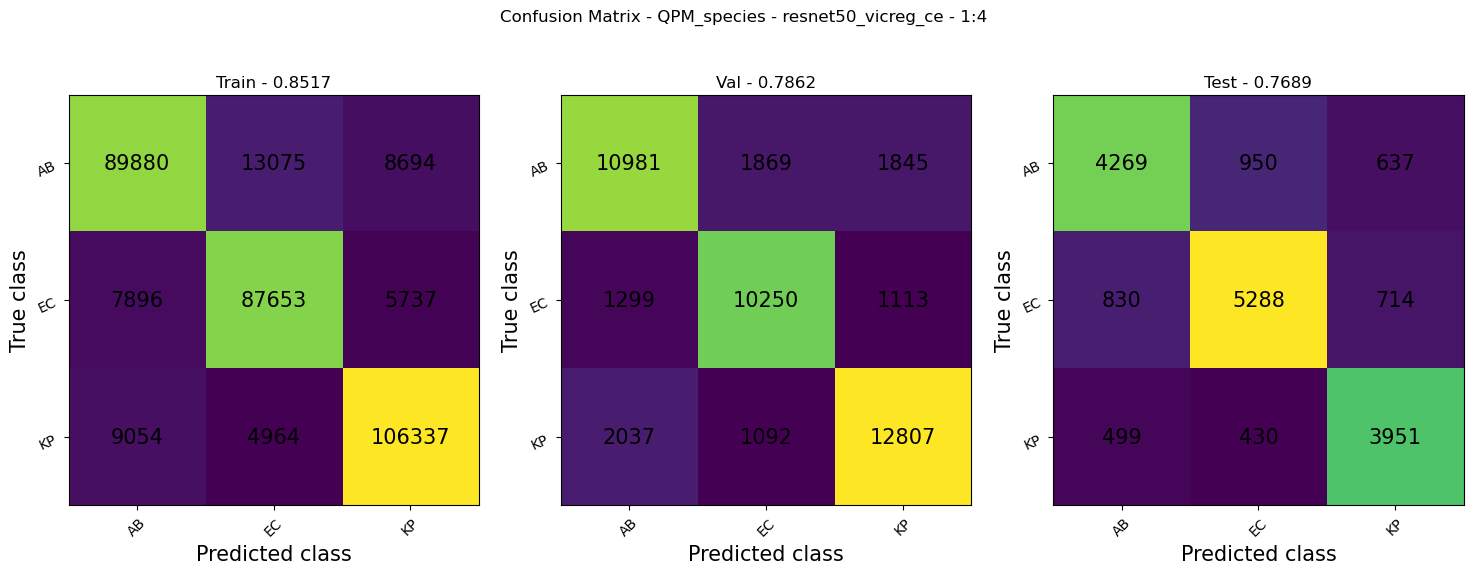

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


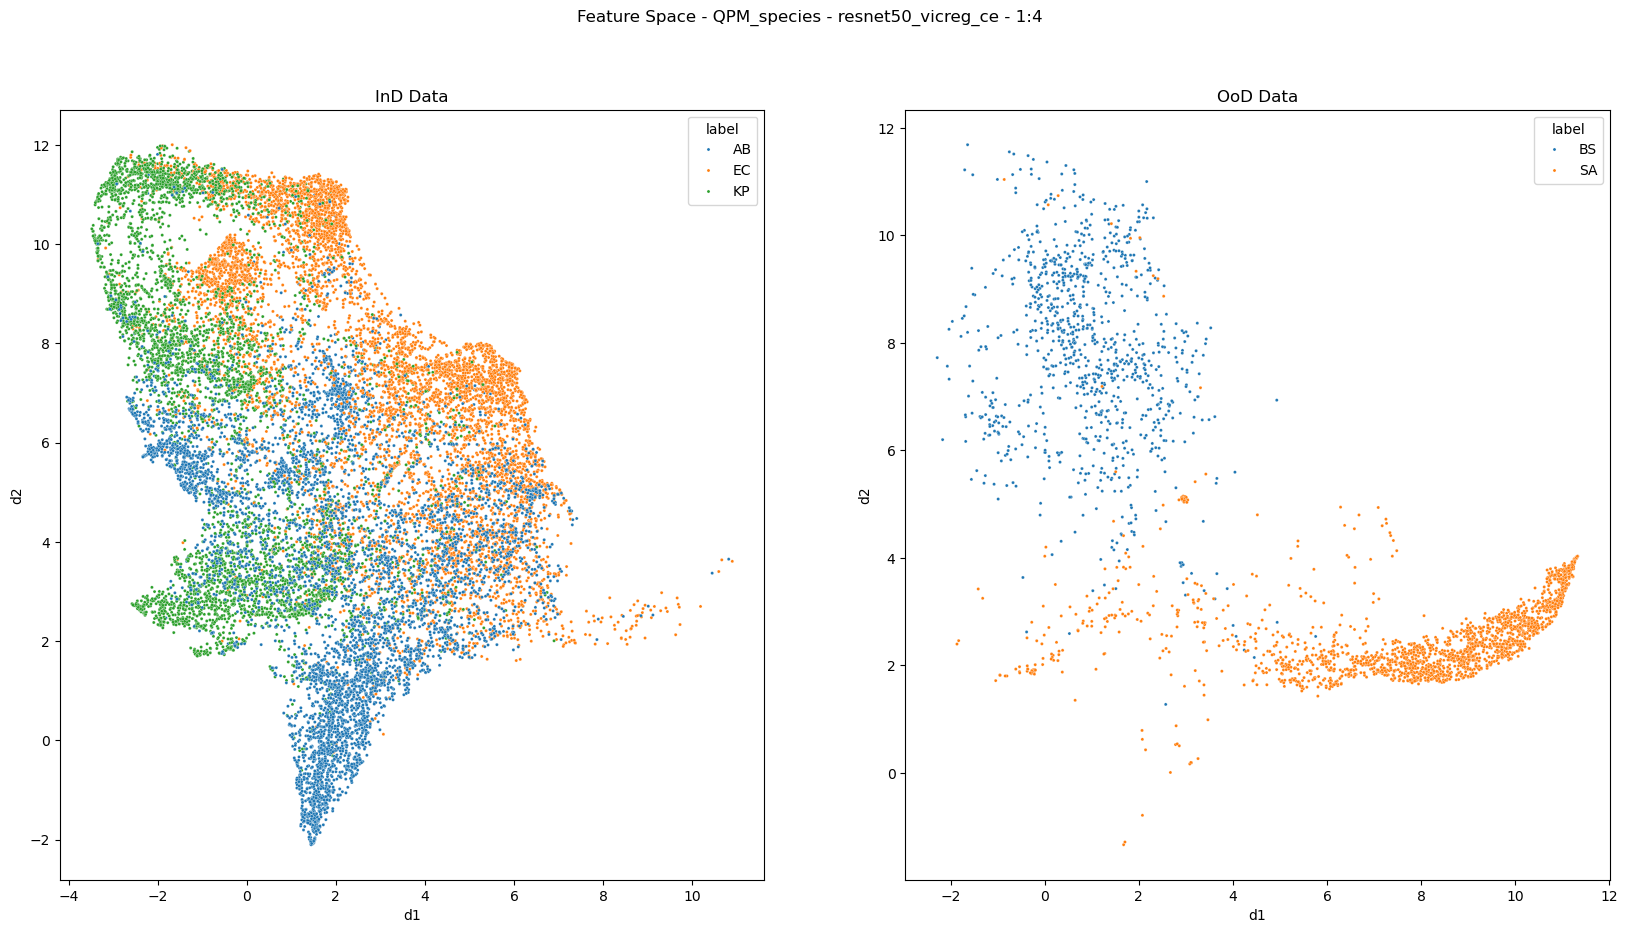

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

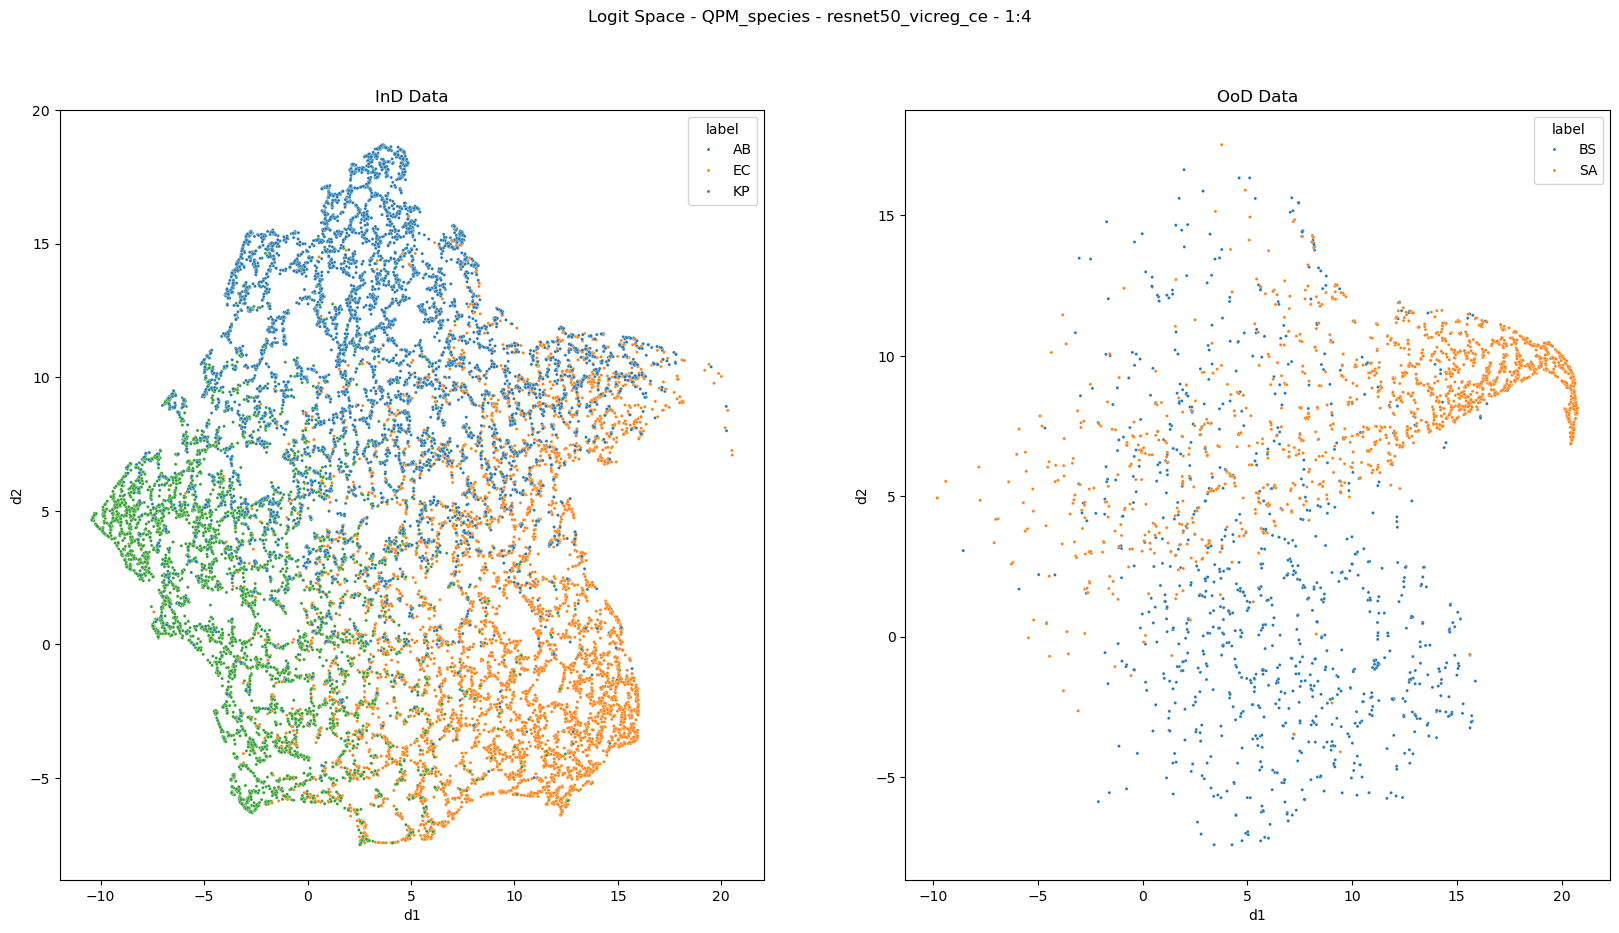

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

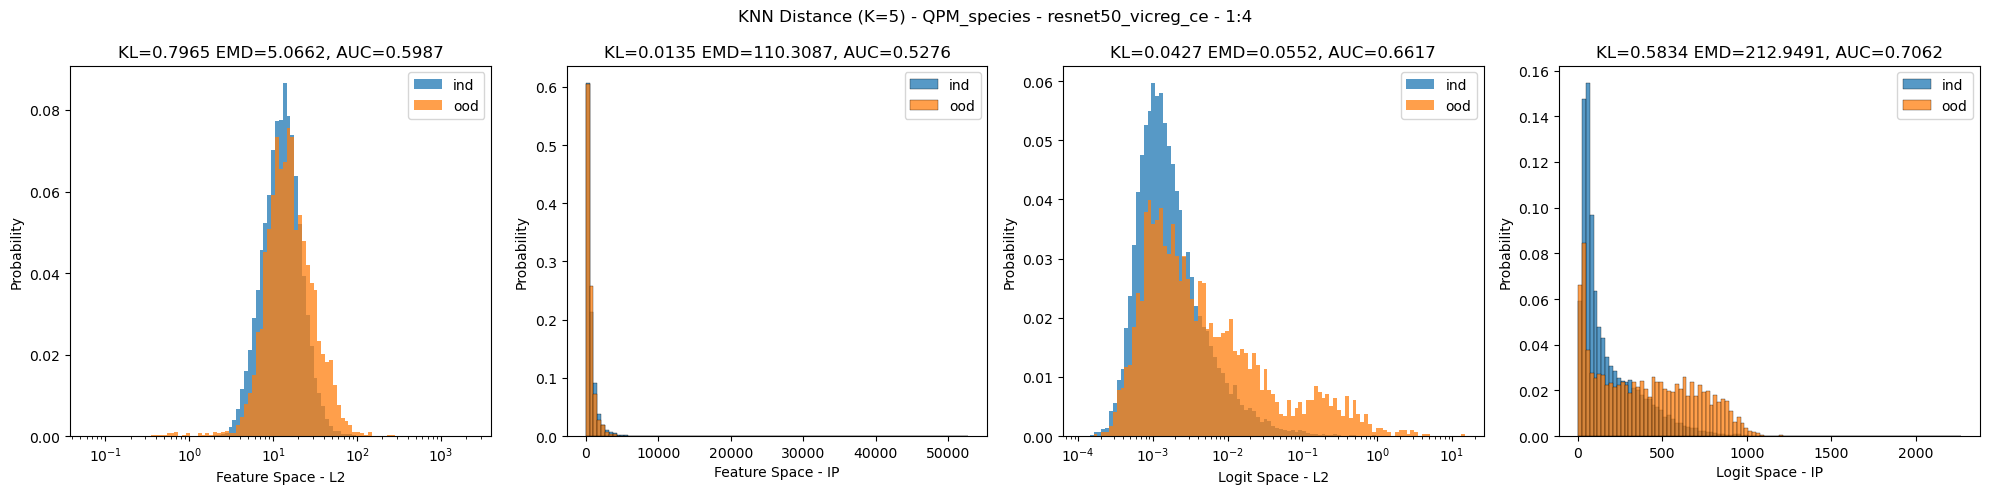

In [15]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

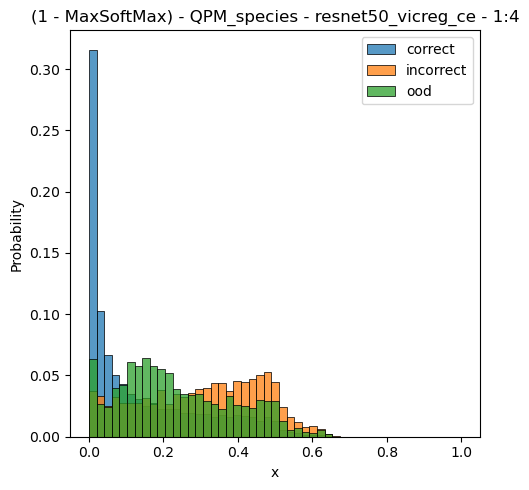

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)